# Try different figure formats to link RS applications and modalities, ML tasks


## Imports


In [15]:
import pandas as pd
from pathlib import Path
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import circlify as circ
import subprocess
import seaborn as sns

from pprint import pprint as pp 
from utils.utils import print_pretty_df, wrap_label
from utils.metadata import plot_colors, general_task_colors

# Quick ANSI color code shortcuts
r = "\033[31m"
y = "\033[33m"
g = "\033[32m"
b = "\033[34m"
e = "\033[0m"

pickleName = "all_datapoints.pkl"
datapointsDfPath = Path("..") / "data" / "Dataframes" / pickleName
datapointsDf = pd.read_pickle(datapointsDfPath)

versionTag = "_v3"
figureName = "Applications_tasks_bubbles" + versionTag
saveFormat = "svg"
transparency = 0.7
saveFigurePath = Path("..") / "data" / "Figures" / "RQ_figures" / f"{figureName}.{saveFormat}"

In [16]:
print_pretty_df(datapointsDf[["BBT Citation Key", "Task", "Dataset", "Application"]].sort_values(by="Application"))
print(datapointsDf["Application"].unique())

+----+-------------------------------------------------------+----------------------+---------------------------------------------------+-----------------------------------------+
|    |                   BBT Citation Key                    |         Task         |                      Dataset                      |               Application               |
+----+-------------------------------------------------------+----------------------+---------------------------------------------------+-----------------------------------------+
| 42 |              huangEdgeTrustworthyAI2024               |    Classification    |         UAV RGB (cust.) {Classification}          |         Air Quality Monitoring          |
| 53 |          gargAircraftDetectionSatellite2024           |   Object detection   |             Airbus {Object Detection}             |           Aircraft detection            |
| 29 |           wuDesignImplementationRemote2021            |   Object detection   | Google Earth S

### Group application by thematic


In [17]:
datapointsDf.replace({
    'Redshift estimation [regression]': 'Redshift estimation',
    'Railway track fastener defect detection': 'Railway defects detection',
    'Diverse': 'Miscellaneous targets',
    'General': 'Unsupervised'
}, inplace=True)

application_to_group = {
    #  --- Environmental Monitoring --- 
    "Cloud coverage": "Environmental Monitoring",
    "Air Quality Monitoring": "Environmental Monitoring",
    "Deforestation detection": "Environmental Monitoring",
    "Oil spills feature extraction": "Environmental Monitoring",
    #  --- Landscape Analysis --- 
    "Landcover/Land use": "Landscape Analysis",
    "Anomaly detection": "Landscape Analysis",
    "Urban areas": "Landscape Analysis",
    "Unsupervised": "Landscape Analysis",

    #  --- Target Detection --- 
    "Ship detection": "Target Detection",
    "Ship identification": "Target Detection",
    "Aircraft detection": "Target Detection",
    "Flying-object detection": "Target Detection",
    "Military targets identification": "Target Detection",
    "Miscellaneous targets": "Target Detection",
    "Railway defects detection": "Target Detection", # Diverse?
    #  --- Miscellaneous (Diverse) --- 
    # "Redshift estimation": "Diverse",
    
    #  --- Navigation --- 
    "UAV obstacles detection": "Navigation",
    "Safe UAV landing site identification": "Navigation",
}

# Check
for app in datapointsDf["Application"].unique():
    if app not in application_to_group:
        print(f"Application '{r}{app}{e}' not in application_to_group")

### Circular patches

The computations for the circles sizes and positions is made with `circlify`, see their [GitHub](https://github.com/elmotec/circlify/tree/main) for examples.
The plotting is based on `circlify.bubbles` function (using `matplotlib`), but I made it a wee bit more elaborated (and fit to my needs obviously).

Use the circles' colors to indicate **Tasks** and hatching patterns for **Modalities**.


In [18]:
def get_task_for_application(app, df):
    """
    Retrieves the ML task for a given application name from the provided DataFrame.
    If multiple tasks exist, pick the most frequent one.
    """
    tasks = df[df['Application'] == app]['Task']
    if len(tasks) == 0:
        return None
    return tasks.value_counts().idxmax()

def get_task_color(app, df, task_colors):
    """
    Returns a color corresponding to the task of the given application.
    If no matching task is found, defaults to white.
    """
    task = get_task_for_application(app, df)
    return task_colors.get(task, 'white')

def get_modality_hatch_pattern(app, hatch_patterns):
    """
    Returns a hatch pattern based on the application modality.
    If multiple modalities exist, pick the most frequent one (or combine if needed).
    """
    # Example approach: you might have another function or DataFrame to look up the modalities
    # For now, assume the user has a function called get_modality_hatch_pattern(...) or similar
    return determine_hatch_pattern(app, hatch_patterns, 'Modality')  # reusing existing approach

def determine_hatch_pattern(app, patterns, column='Modality'):
    """
    Returns a hatch pattern based on a Dataframe column.
      1. If a single instance (of the column) is found in >= 70% of the rows, return its pattern.
      2. Otherwise, if at least two modalities are present:
         If the top two instances occur with roughly close frequency, combine their patterns.
         Otherwise, return only the top instance's pattern.
      3. If no matches or empty, return an empty pattern.

    'patterns' is a dict like (for modalities):
        {
         'RGB': '//',
         'HSI': '||',
         'SAR': '++',
         '1D': '*',
        }
    """
    applications = datapointsDf[datapointsDf['Application'] == app][column]
    if column == 'Modality': applications = applications.replace({'RGB + infrared': 'RGB', 'RGB + MMW': 'RGB'})

    if len(applications) == 0:
        return ""

    # Get frequencies of each instance
    counts = applications.value_counts()
    total = counts.sum()
    if len(counts) == 1: return patterns.get(counts.index[0], "")

    # Sort by frequency (already sorted from value_counts by default), check if top instance >= 70%
    topInstance = counts.index[0]
    topCount = counts.iloc[0]
    if topCount / total >= 0.7:
        return patterns.get(topInstance, "")

    # Otherwise, check if second-most frequent is "roughly" close
    if len(counts) >= 2:
        secondInstance = counts.index[1]
        secondCount = counts.iloc[1]

        # Let's say "roughly close" means the ratio of secondCount to topCount is at least 0.7
        if secondCount / topCount >= 0.7:
            patternA = patterns.get(topInstance, "")
            patternB = patterns.get(secondInstance, "")
            return patternA + patternB
        else:
            return patterns.get(topInstance, "")

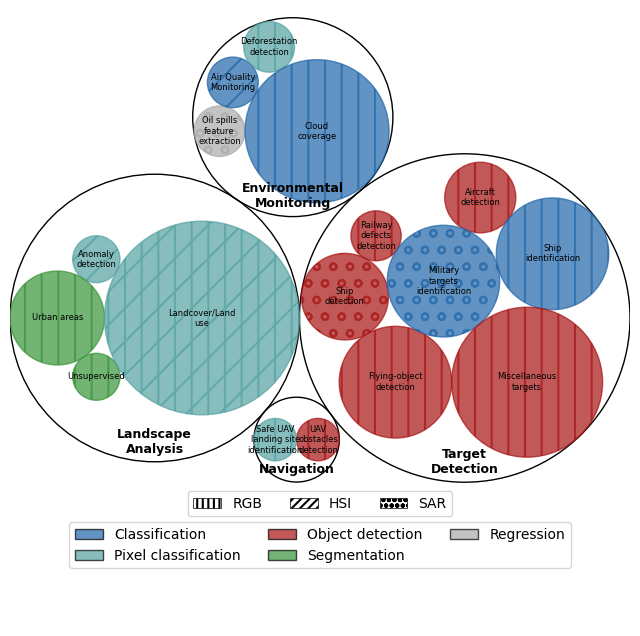

In [24]:
def plot_bubbles_custom_tasks_color(
    circles,
    labels,
    df_for_tasks,
    task_colors,
    hatch_patterns=None,
    fontsize=8,
    lim=None,
    withBase=True,
    title="",
):
    """
    Variation of plot_bubbles_custom that:
      - Leaves group-level circles white (with borders).
      - Child-level circles are colored by ML Task (from df_for_tasks).
      - Maintains the hatch pattern for modalities if not 'None'.
      - Adds legends for tasks (color) and modalities (hatch).
    """
    withHatch = False if hatch_patterns is None else True
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.axis('off')  # Remove all axes/borders
    plt.rcParams['hatch.linewidth'] = 1.5

    # Identify circles
    base_circle = circles[0]
    base_label = labels[0]
    group_circles = []
    child_circles = []
    for c_obj, lbl in zip(circles[1:], labels[1:]):
        if c_obj.level == 1:
            group_circles.append((c_obj, lbl))
        elif c_obj.level == 2:
            child_circles.append((c_obj, lbl))
        else:
            raise ValueError(f"Circles with Levels higher than 2 not supported: {c_obj}, level {c_obj.level}")

    # Draw the base circle (enclosure)
    if withBase:
        ax.add_patch(
            plt.Circle(
                (base_circle.x, base_circle.y),
                base_circle.r,
                fill=False,
                linewidth=1
            )
        )
        ax.text(
            base_circle.x,
            base_circle.y - base_circle.r + 0.2,
            "Addressed RS Applications",
            ha='center',
            va='center',
            fontsize=fontsize + 5
        )

    # Draw group-level circles: no fill, just a border, bigger label at bottom
    for c_obj, lbl in group_circles:
        x, y, r = c_obj.x, c_obj.y, c_obj.r
        ax.add_patch(
            plt.Circle(
                (x, y),
                r,
                fill=False,  # no color fill
                linewidth=1,
                edgecolor='black'
            )
        )
        ax.text(
            x,
            y - r + 0.02,
            wrap_label(lbl, 10),
            ha='center',
            va='bottom',
            fontsize=fontsize + 3,
            fontweight='bold'
        )

    # Draw child-level circles: color by task, hatch by modality
    for c_obj, lbl in child_circles:
        x, y, r = c_obj.x, c_obj.y, c_obj.r
        # color from the tasks in df_for_tasks
        circle_color = get_task_color(lbl, df_for_tasks, task_colors)
        # hatch from the modalities
        circle_hatch = determine_hatch_pattern(lbl, hatch_patterns, 'Modality') if withHatch else None

        ax.add_patch(
            plt.Circle(
                (x, y),
                r,
                alpha=transparency,
                linewidth=1,
                fill=True,
                facecolor=circle_color,
                edgecolor=circle_color,
                hatch=circle_hatch,
            )
        )
        ax.text(
            x,
            y,
            wrap_label(lbl, 12),
            ha='center',
            va='center',
            fontsize=fontsize
        )

    # Auto-limit the axes if lim is not provided
    if lim is None:
        lim = max(
            max(abs(c_obj.x) + c_obj.r, abs(c_obj.y) + c_obj.r)
            for c_obj in circles
        )
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)

    # Build legend for tasks (colors)
    task_patches = []
    for tsk, clr in task_colors.items():
        task_patches.append(
            mpatches.Patch(facecolor=clr, edgecolor='black', label=tsk, alpha=transparency)
        )
    ax.add_artist(ax.legend(handles=task_patches, fontsize=10, loc="upper center", bbox_to_anchor=(0.5, 0.18), ncol=3))

    # Build legend for modalities (hatches)
    if withHatch:
        modality_patches = []
        for modality, pat in hatch_patterns.items():
            patch = mpatches.Patch(
                    facecolor='white',
                    edgecolor='black',
                    hatch=pat*4 if (pat == '/') else pat*3,
                    label=modality,
                    linewidth=0.5
                )
            modality_patches.append(patch)
        ax.legend(handles=modality_patches, fontsize=10, loc="upper center", bbox_to_anchor=(0.5, 0.23), ncol=4)

    plt.title(title)

    # Create two distinct paths: one for SVG, one for PDF
    svg_path = saveFigurePath.with_suffix(".svg")  # your "saveFigurePath" usually ends with .svg
    pdf_path = saveFigurePath.with_suffix(".pdf")  # output the final PDF

    # Save figure to SVG first
    fig.savefig(svg_path, format="svg", bbox_inches="tight")

    plt.show()

# Ensure 'Group' column is present in the DataFrame
datapointsDf['Group'] = datapointsDf['Application'].map(application_to_group)

# Build a DataFrame of counts grouped by (Group, Application)
df_counts = datapointsDf[['Group', 'Application']].value_counts().reset_index(name='Count')
df_counts.columns = ['Group', 'Application', 'Count']
df_counts.sort_values(by=['Group'], inplace=True)

# Build hierarchical data for circlify
data = []
for group_val, group_subset in df_counts.groupby('Group'):
    total_count = group_subset['Count'].sum()
    children = []
    for _, row in group_subset.iterrows():
        children.append({'id': row['Application'], 'datum': row['Count']})
    data.append({
        'id': group_val,
        'datum': total_count,
        'children': children
    })
circles = circ.circlify(data, show_enclosure=True)
labels = [c.ex.get("id", "") if c.ex else "" for c in circles]

# Prepare color dictionary for tasks
# Make a list of default colors for the groups (5 first circles)
# Blue (Matisse) 1f77b4
# Orange (Flamenco) ff7f0e
# Red (Punch) d62728
# Green (Forest Green) 2ca02c
# Purple (Wisteria) 9467bd
task_colors = general_task_colors

# Prepare hatch patterns for modalities
modality_patterns = {
    'RGB': '|',
    'HSI': '/',
    'SAR': 'o',
    # '1D': '*',
}

# # ----- Plot v1: Tasks only -----
# plot_bubbles_custom_tasks_color(
#     circles=circles,
#     labels=labels,
#     df_for_tasks=datapointsDf,  # the complete DF to query tasks
#     task_colors=task_colors,
#     hatch_patterns=None,
#     fontsize=6,
#     withBase=False,
#     title="V1: Hierarchical Circle Packing with Tasks"
# )

# ----- Plot v2: Tasks and Modalities -----
plot_bubbles_custom_tasks_color(
    circles=circles,
    labels=labels,
    df_for_tasks=datapointsDf,  # the complete DF to query tasks
    task_colors=task_colors,
    hatch_patterns=modality_patterns,
    fontsize=6,
    withBase=False,
    title="", #"V2: Hierarchical Circle Packing with Tasks and Modalities"
)

## Older Figures

### Classic bar plotting


C:\Users\leon_ce\AppData\Local\Temp\ipykernel_9700\1443511467.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bottom_stack[i] + val / 2,


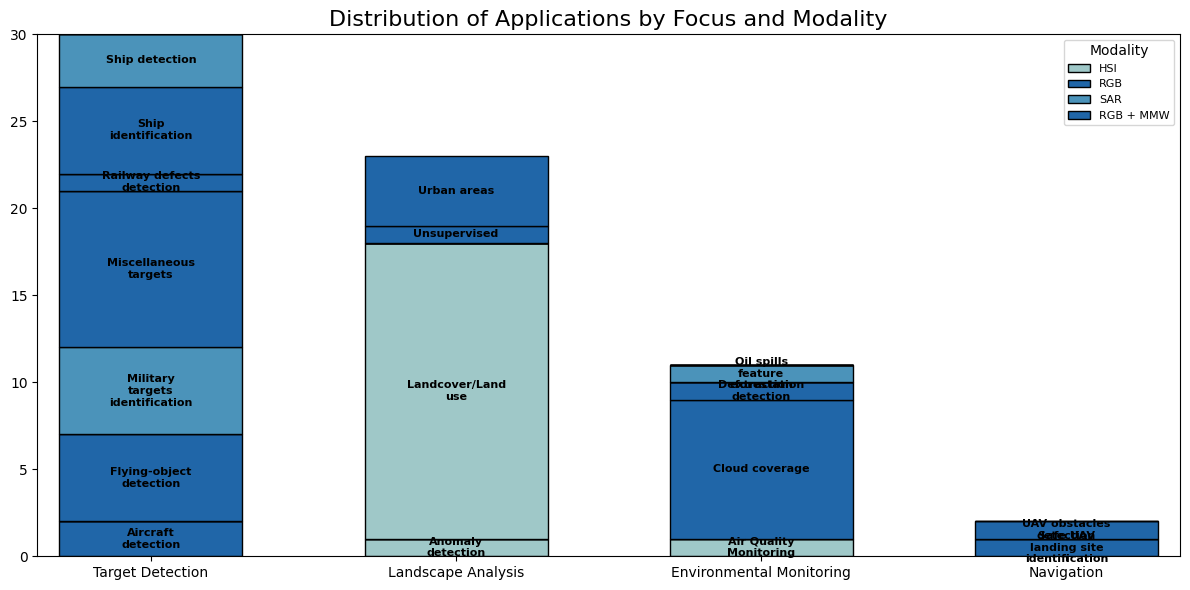

In [20]:
def get_modality_color(modality_str):
    # Custom mapping:
    # - If "RGB" in the string, use blue
    # - "HSI" => purple
    # - "SAR" => gray
    # - "1D" => no fill (white)
    # Default => some fallback color
    if "RGB" in modality_str.upper():
        return "#2066a8"
    elif modality_str.upper() == "HSI":
        return "#9fc8c8"
    elif modality_str.upper() == "SAR":
        return "#4B93BA"
    elif modality_str.upper() == "1D":
        return "none"  # White or transparent
    raise ValueError(f"Unknown modality: {modality_str}")
    # "Classification": "#2066a8",
    # "Pixel classification": "#1f6f6f",
    # "Segmentation": "#9fc8c8",
    # "Object detection": "#af2c2c",
    # "Regression": "#4B93BA",

def plot_stacked_bar_with_modality_colors(data):
    # Prepare DataFrame
    df = data.reset_index(name='Count')
    df['Application Wrapped'] = df['Application'].apply(wrap_label)

    # Pivot with sum to handle duplicates
    pivot_df = df.pivot_table(
        index='Group',
        columns='Application Wrapped',
        values='Count',
        aggfunc='sum',
        fill_value=0
    )

    # Sort tasks by total count descending (biggest on left, smallest on right)
    pivot_df = pivot_df.loc[pivot_df.sum(axis=1).sort_values(ascending=False).index]

    # Keep track of which modalities have been labeled
    already_labeled = set()

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    bottom_stack = np.zeros(len(pivot_df))

    for app in pivot_df.columns:
        # Find a representative row in df for this app
        # (Pick the first match to get its modality)
        sub_df = df.loc[df['Application Wrapped'] == app]
        if not sub_df.empty:
            modality = sub_df.iloc[0]['Modality']
            bar_color = get_modality_color(modality)
        else:
            # Fallback if not found
            modality = "Unknown"
            bar_color = "lightgray"

        # Show each modality in legend only once
        if modality not in already_labeled:
            label_for_legend = modality
            already_labeled.add(modality)
        else:
            label_for_legend = None

        ax.bar(
            pivot_df.index,
            pivot_df[app],
            bottom=bottom_stack,
            label=label_for_legend,
            color=bar_color,
            edgecolor='black',
            width=0.6
        )

        # Add labels to each sub-bar (in black)
        for i, val in enumerate(pivot_df[app]):
            if val > 0:
                ax.text(
                    i,
                    bottom_stack[i] + val / 2,
                    app,
                    ha='center',
                    va='center',
                    fontsize=8,
                    color='black',
                    fontweight='bold'
                )

        bottom_stack += pivot_df[app]

    # Customization
    ax.set_title("Distribution of Applications by Focus and Modality", fontsize=16)
    ax.set_xticks(range(len(pivot_df.index)))
    ax.set_xticklabels(pivot_df.index, rotation=0, fontsize=10)  # No rotation
    ax.legend(title='Modality', loc='upper right', fontsize=8)
    ax.margins(x=0.02)  # Less space behind bars
    plt.tight_layout()
    plt.show()

# Example usage
data = datapointsDf[["Modality", "Application", "Group"]].value_counts()
plot_stacked_bar_with_modality_colors(data)

### Minimal Working Example: `matplotlib` colored hatching invisble in PDF format

See [open mpl issue](https://github.com/matplotlib/matplotlib/issues/12367)


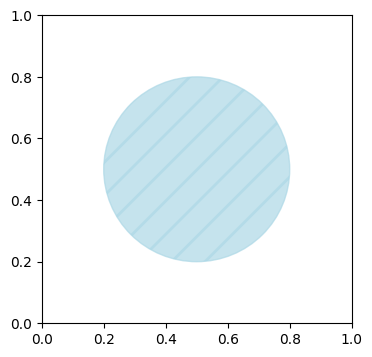

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_hatched_circle():
    fig, ax = plt.subplots(figsize=(4,4))

    ax.add_patch(patches.Circle(
        (0.5, 0.5),
        0.3,
        color='lightblue',      # Use color or facecolor+edgecolor
        alpha=0.7,
        hatch='/',              # Any pattern: '/', '|', 'x', 'o', etc.
        # edgecolor='lightblue',
    ))
    plt.savefig("hatched_circle.png", dpi=300)
    plt.savefig("hatched_circle.pdf", dpi=300)
    plt.show()

if __name__ == "__main__":
    draw_hatched_circle()